In [1]:
#importing the Packages
import pandas as pd
import nltk
from nltk import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from random import shuffle
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from nltk.classify import ClassifierI
from statistics import mode

#Type of stemmer used and allowed word types
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update(('.', '..', '...', '....', ':', ':-)', ':)', '!', '!!', '!!!', '?', '??',','))
allowed_word_types = ["J","R","V","N"]    #j is adjective, r is adverb, v is verb and n is noun


In [2]:
#The Class declaration
class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)
    
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        
        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

In [3]:
#Building the bag of words
document =[]
bow = []

for i, chunk in enumerate(pd.read_csv('Twitter.csv', chunksize = 1000, header = None )):
    a = chunk.iloc[:,0]
    for j in range(len(a)):
        if (a.iloc[j] == 0):
            words = []
            filtered_words = []
            stemmed_words = []
            lemm_words = []
            df1 = str(chunk.iloc[j,5])
            document.append((df1,a.iloc[j]))
            words = word_tokenize(df1)
            for w in words:
                stemmed_words.append(ps.stem(w))
            for w in stemmed_words:
                lemm_words.append(lemmatizer.lemmatize(w))
            #pos = nltk.pos_tag(lemm_words)
            #for w in pos:
                #if w[1][0] in allowed_word_types:
                    #bow.append(w[0].lower())
            for w in lemm_words:
                bow.append(w.lower())
                
                
        if (a.iloc[j] == 4):
            words = []
            filtered_words = []
            stemmed_words = []
            lemm_words = []
            df1 = str(chunk.iloc[j,5])
            document.append((df1,a.iloc[j]))
            words = word_tokenize(df1)
            for w in words:
                stemmed_words.append(ps.stem(w))
            for w in stemmed_words:
                lemm_words.append(lemmatizer.lemmatize(w))
            #pos = nltk.pos_tag(lemm_words)
            #for w in pos:
             #   if w[1][0] in allowed_word_types:
             #     bow.append(w[0].lower())
            for w in lemm_words:
                bow.append(w.lower())
                    
freq_words = FreqDist(bow)
word_features = list(freq_words.keys())[:5000]


In [4]:
print (len(bow))
print (len(word_features))

260464
5000


In [5]:
def find_features(document):
    words = []
    filtered_words = []
    stemmed_words = []
    lemm_words = []
    words = word_tokenize(document)
    for w in words:
        stemmed_words.append(ps.stem(w))
    for w in stemmed_words:
        lemm_words.append(lemmatizer.lemmatize(w))
    
    features = {}
    for w in word_features:
        features[w] = (w in lemm_words)

    return features 

In [6]:
#Finding the features for all the tweets
featuresets = []

for (tweet, category) in document:
    featuresets.append((find_features(tweet),category))

l = len(featuresets)
print (l)

19982


In [8]:
del document[:]

In [9]:
from random import shuffle
shuffle(featuresets)

training_set = featuresets[:16000]
testing_set = featuresets[16000:]

In [10]:
clf = nltk.NaiveBayesClassifier.train(training_set)
print(" Naive Bayes accuracy percent",(nltk.classify.accuracy(clf, testing_set))*100)

 Naive Bayes accuracy percent 70.56755399296836


In [11]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("Multinomial Naive Bayes accuracy percent",(nltk.classify.accuracy(MNB_classifier, testing_set))*100)


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("Bernoulli Naive Bayes accuracy percent",(nltk.classify.accuracy(BNB_classifier, testing_set))*100)

Multinomial Naive Bayes accuracy percent 71.99899547965846
Bernoulli Naive Bayes accuracy percent 70.69311903566047


In [12]:
LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("Logistic Regression accuracy percent",(nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

Logistic Regression accuracy percent 72.95328980411854


In [13]:
SGD_classifier = SklearnClassifier(SGDClassifier())
SGD_classifier.train(training_set)
print("Stochastic gradient decent accuracy percent",(nltk.classify.accuracy(SGD_classifier, testing_set))*100)

/Users/georgeboben/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Stochastic gradient decent accuracy percent 67.02661978905073


In [14]:
voted_classifier = VoteClassifier(clf, 
                                  MNB_classifier, 
                                  BNB_classifier, 
                                  LogisticRegression_classifier, 
                                  SGD_classifier)
print("Voted Classifier accuracy percent",(nltk.classify.accuracy(voted_classifier,testing_set))*100)

Voted Classifier accuracy percent 72.40080361627324


In [15]:
print("Classification:" , voted_classifier.classify(testing_set[1][0]), "Confidence %:", voted_classifier.confidence(testing_set[1][0])*100)
print("Classification:" , voted_classifier.classify(testing_set[2][0]), "Confidence %:", voted_classifier.confidence(testing_set[2][0])*100)
print("Classification:" , voted_classifier.classify(testing_set[3][0]), "Confidence %:", voted_classifier.confidence(testing_set[3][0])*100)
print("Classification:" , voted_classifier.classify(testing_set[4][0]), "Confidence %:", voted_classifier.confidence(testing_set[4][0])*100)
print("Classification:" , voted_classifier.classify(testing_set[5][0]), "Confidence %:", voted_classifier.confidence(testing_set[5][0])*100)

Classification: 4 Confidence %: 80.0
Classification: 4 Confidence %: 100.0
Classification: 0 Confidence %: 100.0
Classification: 4 Confidence %: 100.0
Classification: 0 Confidence %: 100.0


In [42]:
def sentiment(text):
    feats = find_features(text)
    print("Classification:" , voted_classifier.classify(feats), "Confidence %:", voted_classifier.confidence(feats)*100)

In [43]:
text = "The Movie was bad, but overall script was good"
print(sentiment(text))

Classification: 4 Confidence %: 60.0
None


In [33]:
m = l-16001
ypred = []
yactual = []
for i in range(m):
    yprediction = voted_classifier.classify(testing_set[i][0])
    ypred.append(yprediction)
    yactual1 = testing_set[i][1]
    yactual.append(yactual1)

[[1326  434]
 [ 665 1556]]

Normalized confusion matrix
[[0.75340909 0.24659091]
 [0.29941468 0.70058532]]


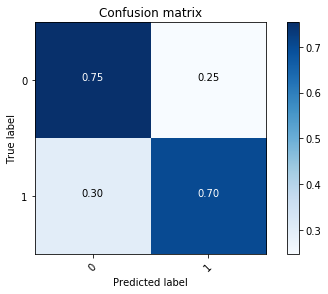

In [34]:
from sklearn.metrics import confusion_matrix
import itertools
import sklearn as skl_lm
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(ypred, yactual)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
print('')
plot_confusion_matrix(cm,[0,1],normalize=True)
plt.show()